# Выбор локации для скважины

В рамках проекта необходимо построить модель для задачи регрессии.

Необходимо предложить добывающей компании «ГлавРосГосНефть» решение о том, где бурить новую скважину.

В качестве исходных данных используются пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерено качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Этапы построения модели:

- Подготовка данных;
- Обучение модели и оценка объема запасов;
- Подготовка необходимых значений для расчета прибыли;
- Расчет прибыли;
- Оценка рисков и прибыли и выбор региона.

## Загрузка и подготовка данных

Импортирт библиотек:

In [55]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import ttest_1samp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Чтение файлов:

In [56]:
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

Выведем основную информацию о данных методом `info()`.

In [57]:
data_0.info()
print()
data_1.info()
print()
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

Выведем основные статистики данных методом `describe`.

In [58]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [59]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [60]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Средние признаков во всех трех таблицах отличны от нуля, значит, данные необходимо масштабировать.

Проверим данные на дубликаты.

In [61]:
data_0.duplicated().sum()

0

In [62]:
data_1.duplicated().sum()

0

In [63]:
data_2.duplicated().sum()

0

Явных дубликатов нет.

По условию задачи необходимо использовать модель линейной регрессии. Для наиболее точной работы модели проверим признаки на надичие мультиколлинеарности. Для этого выведем матрицу коррелиции для каждой таблицы.

In [64]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [65]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [66]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


<a id='1_corr'></a>Корреляция между столбцами во всех таблицах достаточно слабая, мультиколлинеарности нет. Для второго региона есть очень сильная линейная связь целевого признака и столбца `'f2'`, так как коэффициент корреляции равен 0,999.

Изучим первые 5 строк первой таблицы, так как данные в таблицах идентичны по условию.

In [67]:
data_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Каждый объект в таблицах - это данные геологоразведки трёх регионов:

- `'id'` — уникальный идентификатор скважины;
- `'f0'`, `'f1'`, `'f2'` — признаки;
- `'product'` — целевой признак (объём запасов в скважине, тыс. баррелей).

В каждом датасете 5 столбцов, 100 000 строк, пропусков нет, дубликатов нет, мультиколлинеарности нет. Средние признаков во всех трех таблицах отличны от нуля, значит, данные необходимо масштабировать. Необходимо убрать из таблиц столбец `'id'`, так как он не является признаком объектов.

### Выбор значимых признаков

Удалим из таблиц столбец `'id'`, так как он не относится к признакам объектов.

In [68]:
data_0 = data_0.drop(columns='id')
data_1 = data_1.drop(columns='id')
data_2 = data_2.drop(columns='id')

### Разбиение данных на выборки

Для создания качественной модели данные необходимо разбить на обучающую и валидационную выборки. На валидационной выборке проведем оценку качества модели и проанализируем результаты. 

Отделим целевой признак каждой таблицы и запишем его в соответствующие переменные `target_0`, `target_1`, `target_2`. Остальные признаки запишем в переменные `features_0`, `features_1`, `features_2`. 

In [69]:
features_0 = data_0.drop(columns='product')
target_0 = data_0['product']

features_1 = data_1.drop(columns='product')
target_1 = data_1['product']

features_2 = data_2.drop(columns='product')
target_2 = data_2['product']

Размеры обучающей и валидационной выборок составляют 75 % и 25 % от общих данных. Отделим от общих данных валидационую выборку функцией `train_test_split()`. Чтобы зафиксировать случайное разбиение на выборки, зафиксируем параметр случайного состояния `random_state`.

In [70]:
state = np.random.RandomState(12345)

In [71]:
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=state)

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=state)

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=state)

Выведем размеры полученных выборок.

In [72]:
print(features_0_train.shape,'\n',features_0_valid.shape,sep='')

(75000, 3)
(25000, 3)


### Масштабирование признаков

Чтобы для модели они были равнозначны по влиянию на целевой признак, их нужно масштабировать методом стандартизации `StandardScaler()`.

In [73]:
pd.options.mode.chained_assignment = None

columns = ['f0','f1','f2']

scaler = StandardScaler()
scaler.fit(features_0_train)

features_0_train[columns] = scaler.transform(features_0_train[columns])
features_0_valid[columns] = scaler.transform(features_0_valid[columns])

scaler = StandardScaler()
scaler.fit(features_1_train)

features_1_train[columns] = scaler.transform(features_1_train[columns])
features_1_valid[columns] = scaler.transform(features_1_valid[columns])

scaler = StandardScaler()
scaler.fit(features_2_train)

features_2_train[columns] = scaler.transform(features_2_train[columns])
features_2_valid[columns] = scaler.transform(features_2_valid[columns])

## Обучение и проверка модели

### Обучение модели

Обучим модель линейной регрессии для каждого региона и оценим качество предсказаний на валидационной выборке по метрике RMSE и коэффициенту детерминации R2.

#### Первый регион

Обучим модель линейной регрессии на данных первого региона. Предсказания сохраним ввиде объекта `Series` с исходными индексами для соответствующих скважин. Выведем метрики RMSE и R2.

In [74]:
model = LinearRegression()

model.fit(features_0_train, target_0_train)
predictions_0_valid = pd.Series(data = model.predict(features_0_valid),
                                index=features_0_valid.index.to_list())

print("RMSE модели линейной регрессии на валидационной выборке:",
      (mean_squared_error(target_0_valid,predictions_0_valid))**0.5)
print("Средний запас предсказанного сырья:", predictions_0_valid.mean())

RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813
Средний запас предсказанного сырья: 92.59256778438005


Найдем коэффициент детерминации R2.

In [75]:
print(r2_score(target_0_valid,predictions_0_valid))

0.27994321524487786


RMSE модели на валидационной выборке достаточно велико и составляет почти треть от среднего предсказанного запаса сырья. Коэффициент детерминации больше нуля и имеет достаточно большое значение, значит, модель работает значительно лучше, чем оценка запасов средним.

#### Второй регион

Аналогично обучим и проанализируем модель для второго региона.

In [76]:
model = LinearRegression()

model.fit(features_1_train, target_1_train)
predictions_1_valid = pd.Series(data = model.predict(features_1_valid),
                                index=features_1_valid.index.to_list())

print("RMSE модели линейной регрессии на валидационной выборке:",
      (mean_squared_error(target_1_valid,predictions_1_valid))**0.5)
print("Средний запас предсказанного сырья:", predictions_1_valid.mean())

RMSE модели линейной регрессии на валидационной выборке: 0.8897367737680651
Средний запас предсказанного сырья: 68.76995145799779


Найдем коэффициент детерминации R2.

In [77]:
print(r2_score(target_1_valid,predictions_1_valid))

0.9996264922748638


RMSE модели на валидационной выборке очень мало - оно почти на два порядка меньше среднего предсказанного запаса сырья. Коэффициент детерминации почти равен единице - модель практически идеально предсказывает запасы сырья. Вероятно, это обусловлено тем, что для этих данных между целевым признаком и одним из признаков был очень высокий [коэффициент корреляции](#1_corr).

#### Третий регион

Аналогично обучим и проанализируем модель для третьего региона.

In [78]:
model = LinearRegression()

model.fit(features_2_train, target_2_train)
predictions_2_valid = pd.Series(data = model.predict(features_2_valid),
                                index=features_2_valid.index.to_list())

print("RMSE модели линейной регрессии на валидационной выборке:",
      (mean_squared_error(target_2_valid,predictions_2_valid))**0.5)
print("Средний запас предсказанного сырья:", predictions_2_valid.mean())

RMSE модели линейной регрессии на валидационной выборке: 39.958042459521614
Средний запас предсказанного сырья: 95.08752812252328


Найдем коэффициент детерминации R2.

In [79]:
print(r2_score(target_2_valid,predictions_2_valid))

0.20261508041163934


RMSE модели на валидационной выборке достаточно велико и составляет почти треть от среднего предсказанного запаса сырья. Коэффициент детерминации больше нуля и имеет достаточно большое значение, значит, модель работает значительно лучше, чем оценка запасов средним.

### Выводы

Для первого и третьего регионов модели работают похоже и предсказывают с RMSE, равным примерно треть от среднего предсказанных запасов. Коэффициенты детерминации для них составляют 0,28 и 0,20 соответственно. Модели предсказывают значительно лучше, чем оценка запасов средним.

Для второго региона работа модели сильно отличается от двух других. Модель линейной регрессии предсказывает запасы почти идеально: RMSE модели на валидационной выборке равен 0.89, а коэффициент детерминации R2 почти равен единице. Это может быть связано с тем, что для этих данных между целевым признаком и одним из признаков коэффициент корреляции Пирсона был очень высоким и равнялся 0,999.

## Подготовка к расчёту прибыли

Сохраним все ключевые значения для расчётов прибыли в отдельных переменных.

Данные задачи:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2,5 %. Среди них выбирают регион с наибольшей средней прибылью.

In [80]:
#Количество разрабатываемых скважин в регионе - 200.

N_BUILT_WELLS = 200

#Количество исследуемых скважин в регионе - 500.

N_RESEARCHED_WELLS = 500

#Бюджет на разработку скважин в регионе — 10 000 000 тыс. руб.

BUDGET = 10**7

#Стоимость 1 000 баррелей - 450 тыс. руб.

PRICE = 450

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

Минимальный запас нефти в месторождении, при котором разработка скважины остается безубыточной, определяется нулевой прибылью. В данном случае мы можем вычислить прибыль, как суммарный доход за полный запас нефти в разрабатываемых скважинах региона минус бюджет на разработку скважин в регионе. Тогда минимальный запас нефти для одной скважины будет равен бюджету на регион, деленному на количество разрабатываемых скважин в одном регионе и стоимость 1 000 баррелей.

In [81]:
min_one_reserve = BUDGET / N_BUILT_WELLS / PRICE

print(round(min_one_reserve),'тыс. баррелей')

111 тыс. баррелей


Выведем средний запас нефти среди скважин в каждом регионе.

In [82]:
print(round(target_0.mean()))
print(round(target_1.mean()))
print(round(target_2.mean()))

92
69
95


Полученный минимальный запас больше, чем средний запас сырья среди скважин во всех трех регионах. Значит, для получения положительной прибыли необходимо использовать модель для прогнозирования объема запасов и выбора подходящих скважин.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. На вход она принимает два объекта `Series`: с предсказанными запасами для исследуемых скважин и реальными. По предсказаниям фильтрует заданное количество скважин для разработки с максимальными запасами. Для них по реальным запасам вычисляет прибыль, как доход от полного запаса сырья в скважинах минус бюджет на разработку скважин в регионе.

In [83]:
def income(predicted_reserve,real_reserve):
    
    #Выберем заданное количество скважин с наибольшими значениями предсказанных запасов
    
    predicted_reserve = predicted_reserve.sort_values(ascending=False).head(N_BUILT_WELLS)
    
    return (real_reserve[predicted_reserve.index].sum() * PRICE - BUDGET)

### Первый регион

Для расчета рисков и прибыли с помощью техники Bootstrap с 1000 выборок найдем распределение прибыли. Для этого напишем функцию `bootstrap()`, которая на вход принимает предсказания `predictions_valid`, целевой признак `target_valid` и количество выборок `n_samples`. Функция возвращает `Series` с значениями прибыли для каждой выборки.

In [84]:
def bootstrap(predictions_valid,target_valid,n_samples=1000):
    
    values = []
    
    for i in range(n_samples):
    
        predictions_valid_sampled = predictions_valid.sample(n = N_RESEARCHED_WELLS,
                                                             random_state=state,
                                                             replace=True)
    
        values.append(income(predictions_valid_sampled,target_valid))

    return pd.Series(values)

Применим функцию `bootstrap()` для первого региона.

In [85]:
values_0 = bootstrap(predictions_0_valid,target_0_valid)

Визуализируем полученное распределение на гистограмме.

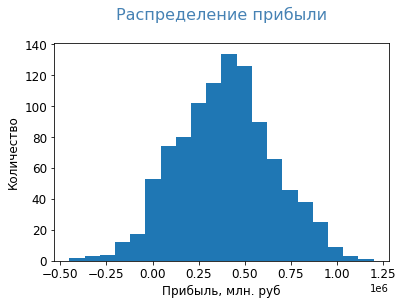

In [86]:
(values_0.plot(kind= 'hist',
               bins=20, 
               figsize=(6,4), 
               legend = False, 
               fontsize = 12)
         .set_title('Распределение прибыли\n', 
                    fontsize = 16, 
                    color = 'SteelBlue'));

plt.xlabel('Прибыль, млн. руб',fontsize = 12)
plt.ylabel('Количество',fontsize = 12)
plt.show()

Найдем среднюю прибыль и сохраним ее в список `mean_income`.

In [87]:
mean_income = []

mean_income.append(values_0.mean())

print("Средняя прибыль:", round(mean_income[-1]), 'тыс. руб')

Средняя прибыль: 394284 тыс. руб


Найдем 95%-й доверительный интервал. Для этого напишем функцию, которая принимает на входе `Series`, возвращает рассчитанный для нее доверительный интервал и выводит его на экран.

In [88]:
def confidence_interval(values):
    
    conf_interval = st.t.interval(alpha=0.95,
                                  df=values.count()-1,
                                  loc=values.mean(),
                                  scale=values.sem())
    
    print("95%-ый доверительный интервал:", conf_interval)
    
    return conf_interval

Найдем доверительный интервал для первого региона.

In [89]:
confidence_interval_0 = confidence_interval(values_0)

95%-ый доверительный интервал: (378182.9698343011, 410385.85284679994)


Найдем риск убытков - вероятность того, что прибыль будет отрицательной. Для этого нужно найти долю отрицательных значений прибыли в распределении. Напишем функцию `risk_of_losses()`, которая на входе принимает `Series`, вычисляет, возвращает и выводит на экран риск убытков.

In [90]:
def risk_of_losses(values):
    
    risk = values[values < 0].count() / values.count()
    
    print('Риск убытков:',risk)
    
    return risk

Применим функцию `risk_of_losses()` к первому региону и запишем найденное значение в список `risks_of_losses`.

In [91]:
risks_of_losses = []

risks_of_losses.append(risk_of_losses(values_0))

Риск убытков: 0.061


### Второй регион

Аналогично рассчитаем прибыль и риски для второго региона. Найдем распределение прибыли функцией `bootstrap()`.

In [92]:
values_1 = bootstrap(predictions_1_valid,target_1_valid)

Найдем среднюю прибыль и сохраним ее в список `mean_income`.

In [93]:
mean_income.append(values_1.mean())

print("Средняя прибыль:", round(mean_income[-1]), 'тыс. руб')

Средняя прибыль: 454736 тыс. руб


Найдем доверительный интервал для второго региона.

In [94]:
confidence_interval_1 = confidence_interval(values_1)

95%-ый доверительный интервал: (441927.75899029244, 467544.9592044231)


Применим функцию `risk_of_losses()` ко второму региону и запишем найденное значение в список `risks_of_losses`.

In [95]:
risks_of_losses.append(risk_of_losses(values_1))

Риск убытков: 0.007


### Третий регион

Аналогично рассчитаем прибыль и риски для третьего региона. Найдем распределение прибыли.

In [96]:
values_2 = bootstrap(predictions_2_valid,target_2_valid)

Найдем среднюю прибыль и сохраним ее в список `mean_income`.

In [97]:
mean_income.append(values_2.mean())

print("Средняя прибыль:", round(mean_income[-1]), 'тыс. руб')

Средняя прибыль: 353664 тыс. руб


Найдем доверительный интервал для первого региона.

In [98]:
confidence_interval_2 = confidence_interval(values_2)

95%-ый доверительный интервал: (337905.0307126234, 369423.1643370454)


Применим функцию `risk_of_losses()` к первому региону и запишем найденное значение в список `risks_of_losses`.

In [99]:
risks_of_losses.append(risk_of_losses(values_2))

Риск убытков: 0.076


### Выводы

Выведем результаты расчета средней прибыли для каждого региона в тыс. руб.

In [100]:
mean_income

[394284.4113405505, 454736.3590973578, 353664.0975248344]

Выведем результаты расчета рисков убытков для каждого региона.

In [101]:
risks_of_losses

[0.061, 0.007, 0.076]

По условию для разработки могут подойти только те регионы, в которых вероятность убытков меньше 2,5 %. Среди них выбирают регион с наибольшей средней прибылью. Под это условие подходит только второй регион с вероятностью убытков 0,7 %. Наибольшая средняя прибыль также у второго региона - 455 млн. руб.

Также для второго региона была получена модель линейной регрессии с наименьшим значением метрики RMSE - 0,89, что говорит о высоком качестве обученной модели. Это может быть связано с тем, что для этих данных между целевым признаком и одним из признаков коэффициент корреляции Пирсона был очень высоким и равнялся 0,999.

Таким образом, на основе полученных моделей и проведенных расчетов в качестве региона для разработки можно предложить второй.